<a href="https://colab.research.google.com/github/hyanquiv/cnn-tests/blob/master/breast_minist_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 130.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.5 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha25

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import medmnist
from medmnist import INFO, Evaluator

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Información del dataset
data_flag = 'breastmnist'
download = True
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# Transformaciones
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Carga de datasets
train_dataset = DataClass(split='train', transform=transform, download=download)
val_dataset = DataClass(split='val', transform=transform, download=download)
test_dataset = DataClass(split='test', transform=transform, download=download)

# Carga en dataloaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 560k/560k [00:00<00:00, 662kB/s]


## Arquitectura de la CNN utilizada

La red neuronal convolucional (CNN) empleada para clasificar imágenes del dataset **BreastMNIST** tiene una estructura simple y eficiente, adecuada para imágenes pequeñas (28x28 píxeles en escala de grises). La arquitectura se compone de las siguientes capas:

1. **Entrada:** Imagen de 1 canal (escala de grises), tamaño 28x28.

2. **Primera capa convolucional:**
   - `Conv2d(1, 32, kernel_size=3, padding=1)`
   - Aplica 32 filtros de tamaño 3x3 con padding 1.
   - Salida: 32 canales de 28x28
   - Activación: `ReLU`
   - Pooling: `MaxPool2d(2)` → reduce tamaño a 14x14

3. **Segunda capa convolucional:**
   - `Conv2d(32, 64, kernel_size=3, padding=1)`
   - Aplica 64 filtros de tamaño 3x3
   - Salida: 64 canales de 14x14
   - Activación: `ReLU`
   - Pooling: `MaxPool2d(2)` → reduce tamaño a 7x7

4. **Capa de aplanamiento:**
   - `Flatten()` convierte la salida 3D en un vector 1D de tamaño 64 × 7 × 7 = 3136

5. **Capa totalmente conectada (FC):**
   - `Linear(3136, 128)`
   - Activación: `ReLU`

6. **Capa de salida:**
   - `Linear(128, 2)` → 2 salidas correspondientes a las clases: **no tumor** (0) y **tumor** (1)

7. **Función de pérdida:**
   - `CrossEntropyLoss`, adecuada para clasificación multiclase (aunque en este caso sea binaria)

8. **Optimizador:**
   - `Adam`, con tasa de aprendizaje de 0.001

---




In [5]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Linear(128, 2)  # BreastMNIST es binario
        )

    def forward(self, x):
        return self.net(x)


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_accuracies = []

for epoch in range(10):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.squeeze().long().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Validacion
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.squeeze().long().to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)
    print(f"Epoch {epoch+1}, Loss: {train_losses[-1]:.4f}, Val Acc: {val_accuracy:.4f}")


Epoch 1, Loss: 0.6012, Val Acc: 0.7308
Epoch 2, Loss: 0.5596, Val Acc: 0.7308
Epoch 3, Loss: 0.5019, Val Acc: 0.7308
Epoch 4, Loss: 0.5062, Val Acc: 0.7821
Epoch 5, Loss: 0.4947, Val Acc: 0.7564
Epoch 6, Loss: 0.5039, Val Acc: 0.8077
Epoch 7, Loss: 0.4814, Val Acc: 0.8077
Epoch 8, Loss: 0.4711, Val Acc: 0.8333
Epoch 9, Loss: 0.4371, Val Acc: 0.8333
Epoch 10, Loss: 0.4454, Val Acc: 0.8590


In [7]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.squeeze().long().to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculo de métricas
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds)
rec = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.8077
Precision: 0.8043
Recall: 0.9737
F1 Score: 0.8810


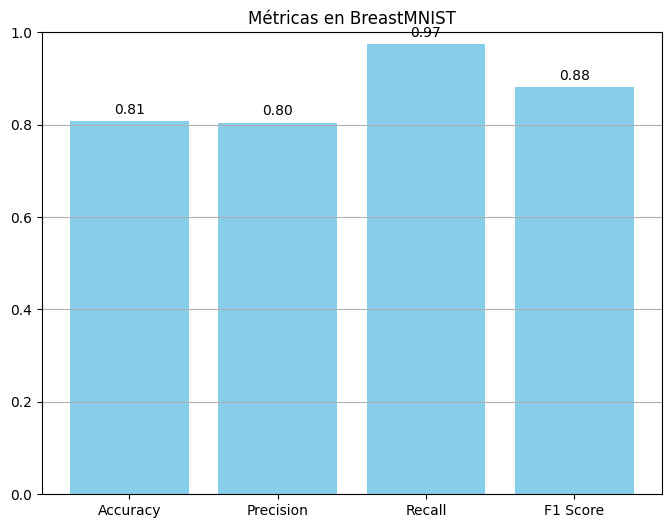

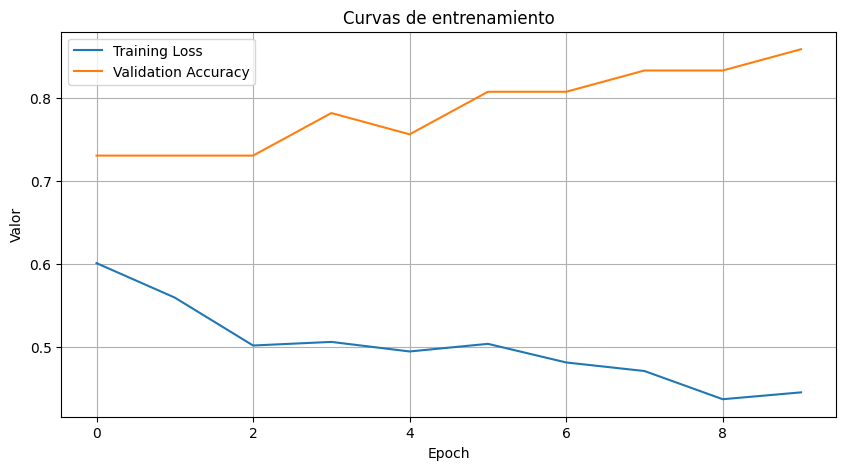

In [10]:
# Plot de métricas
metrics = [acc, prec, rec, f1]
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, metrics, color='skyblue')
for bar, metric in zip(bars, metrics):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{metric:.2f}', ha='center', va='bottom')

plt.ylim(0, 1)
plt.title("Métricas en BreastMNIST")
plt.grid(axis='y')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Valor")
plt.legend()
plt.title("Curvas de entrenamiento")
plt.grid()
plt.show()
